# Initial Analysis of Vocab+Num Design Options

## Tests

In [2]:
def test_add(klass, num):
    for unk in [False, "UNK"]:
        for numericalize in [True, False]:
            voc = klass(unk=unk)
            voc.add("hello")
            if numericalize:
                voc = num(voc)
            assert "hello" in voc.str
            if unk is not False:
                assert unk in voc.str

In [3]:
def test_specials_init(klass, num):
    for unk in [False, "UNK"]:
        for numericalize in [True, False]:
            specs = {"<pad>", "<bos>", "<eos>"}
            voc = klass(specials=specs, unk=unk)
            if numericalize:
                voc = num(voc)
            for spec in specs:
                assert spec in voc.str
            if unk is not False:
                assert unk in voc.str

In [4]:
def test_strip_min_freq(klass, num):
    for numericalize in [True, False]:
        for unk in ["UNK", False]:
            all_words = {"one", "two", "three", "three_again", "four"}
            for freq, *words in [
                    (0, "one", "two", "three", "three_again", "four"),
                    (1, "one", "two", "three", "three_again", "four"),
                    (2, "two", "three", "three_again", "four"),
                    (3, "three", "three_again", "four"),
                    (4, "four")]:
                voc = klass(unk=unk)
                for _ in range(3):
                    voc.add("three")
                for _ in range(2):
                    voc.add("two")
                for _ in range(1):
                    voc.add("one")
                for _ in range(3):
                    voc.add("three_again")
                for _ in range(4):
                    voc.add("four")
                
                if numericalize:
                    voc = num(voc)

                voc.strip(min_freq=freq)
                if unk:
                    assert unk in voc.str
                for word in words:
                    assert word in voc.str
                for word in all_words:
                    if word not in words:
                        try:
                            assert word not in voc.str
                        except:
                            print(f"case numericalize={numericalize} "
                                  f"unk={unk} freq={freq} word={word} failed")

In [5]:
def test_strip_by_n(klass, num):
    for numericalize in [True, False]:
        for unk in ["UNK", False]:
            all_words = {"one", "two", "three", "three_again", "four"}
            for n_words, *words in [
                    (5, "one", "two", "three", "three_again", "four"),
                    (4, "four", "three", "three_again", "two"),
                    (3, "four", "three", "three_again"),
                    (1, "four")]:
                voc = klass(unk=unk)
                for _ in range(3):
                    voc.add("three")
                for _ in range(2):
                    voc.add("two")
                for _ in range(1):
                    voc.add("one")
                for _ in range(3):
                    voc.add("three_again")
                for _ in range(4):
                    voc.add("four")

                if numericalize:
                    voc = num(voc)

                voc.strip(n_to_keep=n_words)
                for word in words:
                    try:
                        assert word in voc.str
                    except:
                        print(f"case IN numericalize={numericalize} "
                              f"unk={unk} n_words={n_words} word={word} failed")
                for word in all_words:
                    if word not in words:
                        try:
                            assert word not in voc.str
                        except:
                            print(
                                f"case NOT_IN numericalize={numericalize} "
                                f"unk={unk} n_words={n_words} word={word} failed")

In [6]:
def test_num_identity(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        voc.add("hello")
        voc = num(voc)
        assert "hello" == voc.str[voc.int["hello"]]

In [7]:
def test_num_identity_unk(klass, num):
    voc = klass(unk="UNK")
    voc = num(voc)
    assert "UNK" == voc.str[voc.int["jambalaya"]]

In [8]:
def test_out_of_vocab_no_unk(klass, num):
    voc = klass(unk=False)
    voc = num(voc)
    try:
        voc.str[voc.int["jambalaya"]]
    except:
        pass  # lol, PASS!
    else:
        assert False

In [9]:
def test_sentence_1d(klass, num):
    fake_data = np.asarray(
        [2, 3, 4, 1, 2]
    )
    expected = np.asarray([
        "two three four"
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data)
    assert (expected == s).all()

In [10]:
def test_sentence_1d_unk(klass, num):
    fake_data = np.asarray(
        [2, 3, 4, 0, 0]
    )
    expected = np.asarray([
        "two three four UNK UNK"
    ])
    voc = klass(unk="UNK")
    for _ in range(6):
        voc.add("one")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, permit_unk=True)
    assert (expected == s).all()

In [11]:
def test_sentence_2d_axis_0(klass, num):
    fake_data = np.asarray(
        [[2, 3, 4, 1, 2],
         [3, 2, 4, 2, 1],
         [2, 3, 0, 0, 0]]
    )
    expected = np.asarray([
        "two three two", "three two three", "four four", "", "two"
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, axis=0)
    assert (expected == s).all()

In [12]:
def test_sentence_2d_axis_1(klass, num):
    fake_data = np.asarray(
        [[2, 3, 4, 1, 2],
         [3, 2, 4, 2, 1],
         [2, 3, 0, 0, 0]]
    )
    expected = np.asarray([
        "two three four", "three two four two", "two three"
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, axis=1)
    assert (expected == s).all()

In [13]:
def test_sentence_3d_axis_2(klass, num):
    fake_data = np.asarray(
        [[[2, 3, 4, 1, 2],
          [3, 2, 4, 2, 1],
          [2, 3, 0, 0, 0]],
         [[1, 0, 0, 0, 0],
          [3, 4, 2, 3, 4],
          [4, 4, 3, 3, 0]]]
    )
    expected = np.asarray([
        ["two three four", "three two four two", "two three"],
        ["", "three four two three four", "four four three three"]
    ])
    voc = klass(specials={"one"}, unk="UNK")
    for _ in range(5):
        voc.add("two")
    for _ in range(4):
        voc.add("three")
    for _ in range(3):
        voc.add("four")
    voc = num(voc)
    s = voc.sentence(fake_data, axis=2)
    assert (expected == s).all()

In [14]:
def test_uncount_and_strip(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        for _ in range(3):
            voc.add("one")
        for _ in range(5):
            voc.add("two")
        for _ in range(3):
            voc.uncount("two")
        voc.strip(min_freq=3)
        assert "one" in voc.str
        assert "two" not in voc.str

In [15]:
def test_uncount_and_strip_numericalized(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        for _ in range(3):
            voc.add("one")
        for _ in range(5):
            voc.add("two")
        for _ in range(4):
            voc.uncount("two")
        voc = num(voc)
        voc.strip(min_freq=3)
        voc.renumericalize()
        
        assert "one" in voc.str
        assert "two" not in voc.str


In [16]:
def test_uncount_to_death(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        for _ in range(3):
            voc.add("one")
        for _ in range(5):
            voc.add("two")
        for _ in range(5):
            voc.uncount("two")
        assert "one" in voc.str
        assert "two" not in voc.str

In [17]:
def test_uncount_to_death_numericalized(klass, num):
    for unk in [False, "UNK"]:
        voc = klass(unk=unk)
        for _ in range(3):
            voc.add("one")
        for _ in range(5):
            voc.add("two")
        voc = num(voc)
        for _ in range(5):
            voc.uncount("two")
        voc.renumericalize()
        assert "one" in voc.str
        assert "two" not in voc.str

In [18]:
def test_all(klass, num):
    tests = [test_add,
             test_specials_init,
             test_strip_min_freq,
             test_strip_by_n,
             test_num_identity,
             test_num_identity_unk,
             test_out_of_vocab_no_unk,
             test_sentence_1d,
             test_sentence_1d_unk,
             test_sentence_2d_axis_0,
             test_sentence_2d_axis_1,
             test_sentence_3d_axis_2,
             test_uncount_and_strip,
             test_uncount_and_strip_numericalized,
             test_uncount_to_death,
             test_uncount_to_death_numericalized]
    for test in tests:
        print(f"Running {test.__name__}")
        test(klass, num)

## Benchmarks

In [19]:
import random

In [20]:
def fake_data(file="rando.txt"):
    # note: inefficient, but who cares?
    with open(file, "r") as f:
        newtxt = []
        txt = f.read()
        for c in txt:
            if c == ".":
                c = " ."
            newtxt.append(c)
    txt = "".join(newtxt).lower()
    txt = txt.replace("\n", "").split(" ")
    return txt

In [21]:
import time

In [22]:
def benchmark_adding_iterable(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        start = time.time()
        voc.add_iterable(txt)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_adding_iterable.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_adding_iterable.__name__, avg)

In [23]:
def benchmark_adding_iterable_numericalized(klass, num, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data("rando_short.txt")
        voc.add_iterable(txt)
        voc = num(voc)
        new_txt = fake_data("rando.txt")
        start = time.time()
        voc.add_iterable(new_txt)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_adding_iterable_numericalized.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_adding_iterable_numericalized.__name__, avg)

In [24]:
def benchmark_numericalizing(voc, num, n_trials=1000):
    queries = list(range(1000))
    start = time.time()
    # TODO: Numericalization is allowed to be destructive. This isn't necessarily right
    for _ in queries:
        _ = num(voc)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_numericalizing.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_numericalizing.__name__, avg)

In [25]:
def benchmark_single_word_random_access(voc, n_trials=1000):
    queries = [random.randint(0, len(voc)-1) for _ in range(n_trials)]
    start = time.time()
    for query in queries:
        _ = voc.str[query]
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_single_word_random_access.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_single_word_random_access.__name__, avg)

In [26]:
def benchmark_1d_word_array_random_access(voc, n_trials=1000):
    lens = [random.randint(3, 12) for _ in range(n_trials)]
    queries = [[random.randint(0, len(voc)-1) for _ in range(len_)] for len_ in lens]
    start = time.time()
    for query in queries:
        _ = voc.str[query]
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_1d_word_array_random_access.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_1d_word_array_random_access.__name__, avg)

In [27]:
def benchmark_1d_word_array_structured_random_access(voc, n_trials=1000):
    seq_len = 20
    queries = [np.random.randint(0, len(voc)-1, (seq_len)) for _ in range(n_trials)]
    start = time.time()
    for query in queries:
        _ = voc.sentence(query, axis=0)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_1d_word_array_structured_random_access.__name__}"
          f" ({n_trials}): {avg} s, avg")
    return (benchmark_1d_word_array_structured_random_access.__name__, avg)

In [28]:
def benchmark_2d_word_array_random_access(voc, n_trials=1000):
    batch = 64
    all_lens = [[random.randint(3, 12) for _ in range(batch)] for _ in range(n_trials)]
    queries = [
        [[random.randint(0, len(voc)-1) for _ in range(l)] for l in lens]
        for lens in all_lens]
    start = time.time()
    for query in queries:
        _ = voc.str[query]
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_2d_word_array_random_access.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_2d_word_array_random_access.__name__, avg)

In [29]:
def benchmark_2d_word_array_structured_random_access(voc, n_trials=1000):
    seq_len = 20
    batch = 64
    queries = [np.random.randint(0, len(voc) - 1, (seq_len, batch)) for _ in range(n_trials)]
    start = time.time()
    for query in queries:
        _ = voc.sentence(query, axis=0)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_2d_word_array_structured_random_access.__name__}"
          f" ({n_trials}): {avg} s, avg")
    return (benchmark_2d_word_array_structured_random_access.__name__, avg)

In [30]:
def benchmark_3d_word_array_structured_random_access(voc, n_trials=1000):
    seq_len = 20
    batch = 64
    beam_size = 10
    queries = [np.random.randint(0, len(voc) - 1, (seq_len, beam_size, batch)) for _ in range(n_trials)]
    start = time.time()
    for query in queries:
        _ = voc.sentence(query, axis=0)
    end = time.time()
    elapsed = end - start
    avg = elapsed / n_trials
    print(f"{benchmark_3d_word_array_structured_random_access.__name__}"
          f" ({n_trials}): {avg} s, avg")
    return (benchmark_3d_word_array_structured_random_access.__name__, avg)

In [31]:
def benchmark_uncounting_iterable(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        txt_to_rm = fake_data("rando_short.txt")
        start = time.time()
        voc.uncount_iterable(txt_to_rm)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_uncounting_iterable.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_uncounting_iterable.__name__, avg)

In [32]:
def benchmark_uncounting_iterable__and_renumericalizing_numericalized(klass, num, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        voc = num(voc)
        txt_to_rm = fake_data("rando_short.txt")
        start = time.time()
        voc.uncount_iterable(txt_to_rm)
        voc.renumericalize()
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_uncounting_iterable__and_renumericalizing_numericalized.__name__} "
          f"({n_trials}): {avg} s, avg")
    return (benchmark_uncounting_iterable__and_renumericalizing_numericalized.__name__, avg)

In [33]:
def benchmark_adding_iterable(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        start = time.time()
        voc.add_iterable(txt)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_adding_iterable.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_adding_iterable.__name__, avg)

In [34]:
def benchmark_strip_n_words(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        n_to_keep = int(len(voc) * 0.20)
        start = time.time()
        voc.strip(n_to_keep=n_to_keep)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_n_words.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_n_words.__name__, avg)

In [35]:
def benchmark_strip_n_words_numericalized(klass, num, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        voc = num(voc)
        n_to_keep = int(len(voc) * 0.20)
        start = time.time()
        voc.strip(n_to_keep=n_to_keep)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_n_words_numericalized.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_n_words_numericalized.__name__, avg)

In [36]:
def benchmark_strip_by_freq(klass, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        start = time.time()
        voc.strip(min_freq=3)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_by_freq.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_by_freq.__name__, avg)

In [37]:
def benchmark_strip_by_freq_numericalized(klass, num, unk, n_trials=10):
    elapsed = 0
    for _ in range(n_trials):
        voc = klass(unk=unk)
        txt = fake_data()
        voc.add_iterable(txt)
        voc = num(voc)
        start = time.time()
        voc.strip(min_freq=3)
        end = time.time()
        elapsed += end - start
    avg = elapsed / n_trials
    print(f"{benchmark_strip_by_freq_numericalized.__name__} ({n_trials}): {avg} s, avg")
    return (benchmark_strip_by_freq_numericalized.__name__, avg)

In [38]:
def benchmarks(klass, num, unk):
    bench = []
    bench.append(benchmark_adding_iterable(klass, unk))
    bench.append(benchmark_adding_iterable_numericalized(klass, num, unk))
    bench.append(benchmark_uncounting_iterable(klass, unk))
    bench.append(benchmark_uncounting_iterable__and_renumericalizing_numericalized(
        klass, num, unk))
    bench.append(benchmark_strip_n_words(klass, unk))
    bench.append(benchmark_strip_n_words_numericalized(klass, num, unk))
    bench.append(benchmark_strip_by_freq(klass, unk))
    bench.append(benchmark_strip_by_freq_numericalized(klass, num, unk))
    
    voc = klass(unk=unk)
    # benchmark
    txt = fake_data()
    voc.add_iterable(txt)
    bench.append(benchmark_numericalizing(voc, num))
    voc = num(voc)
    
    bench.append(benchmark_single_word_random_access(voc))
    
    # 1D word array random access
    bench.append(benchmark_1d_word_array_random_access(voc))
    
    # 1D word array, structured random access
    bench.append(benchmark_1d_word_array_structured_random_access(voc))
    
    # 2D word array, random access
    bench.append(benchmark_2d_word_array_random_access(voc))
    
    # 2D word array, structured random access
    bench.append(benchmark_2d_word_array_structured_random_access(voc))
    
    # 3D word array, structured random access
    bench.append(benchmark_3d_word_array_structured_random_access(voc))
    return dict(bench)

## Interfaces

In [39]:
# set .str
class _DumbStrInterface:
    def __init__(self, s2c):
        self.s2c = s2c
        
    def __contains__(self, str_):
        return str_ in self.s2c
    
# num .str
class _StrInterface:
    def __init__(self, i2s):
        self.i2s = i2s
    
    def __getitem__(self, integer):
        # This could actually be tuned to the implementation
        try:
            return self.i2s[integer]
        except:
            return [self[i] for i in integer]
    
    def __contains__(self, str_):
        return str_ in self.i2s

In [40]:
# num .int (set doesn't have one obviously)
class _IntInterface:
    def __init__(self, s2i, unk):
        self.s2i = s2i
        if unk is not False:
            self.unk = unk
    
    def __getitem__(self, string):
        if isinstance(string, str):
            try:
                return self.s2i[string]
            except KeyError:
                try:
                    return self.unk
                except AttributeError:
                    raise KeyError(f"Couldn't find {string}")
        else:
            return [self[s] for s in string]
    
    def __contains__(self, int_):
        return int_ < len(self.s2i)

In [41]:
class VocabPromise:
    def __init__(self, specials, unk):
        assert isinstance(specials, set)
        assert unk is False or isinstance(unk, str)
        self.unk = unk
        self.specials = specials
        self.str = self.specials
        
    def __len__(self):
        raise NotImplemented()
    
    def add(self, word):
        raise NotImplemented()
    
    def add_iterable(self, words):
        # This could maybe be cythonized for added efficiency
        for word in words:
            self.add(word)
    
    def uncount(self, word):
        raise NotImplemented()
    
    def uncount_iterable(self, words):
        for word in words:
            self.uncount(word)
            
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        raise NotImplemented()

# The Solutions

In [42]:
benches = {}

In [43]:
import numpy as np
from copy import deepcopy
from collections import Counter
import bisect

## Solution 1 - Pure Python

In [44]:
class VocabOne(VocabPromise):
    def __init__(self, specials=set(), unk=False):
        super().__init__(specials=specials, unk=unk)
        self.s2c = Counter()
        self.specials_w_unk = deepcopy(self.specials)
        if self.unk:
            self.specials_w_unk.add(self.unk)
        for word in self.specials_w_unk:
            self.s2c[word] = float("inf")
        self.str = _DumbStrInterface(self.s2c)
        
    def __len__(self):
        return len(self.s2c)
        
    def add(self, word):
        if word in self.s2c:
            self.s2c[word] += 1
        else:
            self.s2c[word] = 1
    
    def uncount(self, word):
        self.s2c[word] -= 1
        if self.s2c[word] == 0:
            del self.s2c[word]
                    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        n_to_keep += len(self.specials_w_unk)
        if n_to_keep < len(self.s2c):
            s2c_n = self.s2c.most_common(n_to_keep)
        else:
            s2c_n = [(s, c) for s, c in self.s2c.items()]

        s2n_f = {s: c for s, c in self.s2c.items() if c >= min_freq}
        if minimal:
            self.s2c = Counter({s: c for s, c in s2c_n if s in s2n_f})
        else:
            s2c_n = Counter(s2c_n)
            s2c_n.update(s_f)
            self.s2c = s2c_n
        self.str = _DumbStrInterface(self.s2c)

In [45]:
class NumericalizationOne(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)

    def sentence(self, integers, axis=0, permit_unk=False):
        shape = list(integers.shape)
        axes = list(range(len(shape)))
        if permit_unk:
            spec_ints = self.specs_as_int
        else:
            spec_ints = self.specs_w_unk_as_int
        del axes[axis]
        axes = [axis] + axes
        del shape[axis]
        strs = np.full(shape, "", dtype=np.object)
        if axis != 0:
            integers = np.transpose(integers, axes)
        frame = integers[0]
        alive = np.isin(frame, spec_ints, invert=True)
        additions = self.str[frame[alive]]
        strs[alive] = additions
        for frame in integers[1:]:
            alive_now = np.isin(frame, spec_ints, invert=True)
            alive = alive & alive_now
            additions = self.str[frame[alive]]
            strs[alive] += " "
            strs[alive] += additions
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [46]:
test_all(VocabOne, NumericalizationOne)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [47]:
bench_1 = benchmarks(VocabOne, NumericalizationOne, unk=False)
benches["pure python"] = bench_1

benchmark_adding_iterable (10): 0.005541849136352539 s, avg
benchmark_adding_iterable_numericalized (10): 0.07511355876922607 s, avg
benchmark_uncounting_iterable (10): 0.00016369819641113282 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00016274452209472657 s, avg
benchmark_strip_n_words (10): 0.0004727363586425781 s, avg
benchmark_strip_n_words_numericalized (10): 3.056526184082031e-05 s, avg
benchmark_strip_by_freq (10): 0.00028810501098632815 s, avg
benchmark_strip_by_freq_numericalized (10): 9.26971435546875e-05 s, avg
benchmark_numericalizing (1000): 0.00038061285018920897 s, avg
benchmark_single_word_random_access (1000): 1.2946128845214845e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.5521049499511718e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 0.0003743069171905518 s, avg
benchmark_2d_word_array_random_access (1000): 9.784483909606934e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00

## Solution 2 - Numpy

In [48]:
class NumericalizationTwo(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=np.unicode)
        del vocab
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)
        self.str = _StrInterface(self.i2s)
    
    def sentence(self, integers, axis=0, permit_unk=False):
        shape = list(integers.shape)
        axes = list(range(len(shape)))
        if permit_unk:
            spec_ints = self.specs_as_int
        else:
            spec_ints = self.specs_w_unk_as_int
        del axes[axis]
        axes = [axis] + axes
        del shape[axis]
        strs = np.full(shape, "", dtype=np.object)
        if axis != 0:
            integers = np.transpose(integers, axes)
        frame = integers[0]
        alive = np.isin(frame, spec_ints, invert=True)
        additions = self.str[frame[alive]]
        strs[alive] = additions
        for frame in integers[1:]:
            alive_now = np.isin(frame, spec_ints, invert=True)
            alive = alive & alive_now
            additions = self.str[frame[alive]]
            strs[alive] += " "
            strs[alive] += additions
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts = np.append(self.cts, 1)
            self.i2s = np.append(self.i2s, word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = self.cts <= 0
        alives = ~kills
        dead_words = self.i2s[kills]
        self.cts = self.cts[alives]
        self.i2s = self.i2s[alives]
        for word in dead_words:
            del self.s2i[word]
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)

    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...

        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [49]:
test_all(VocabOne, NumericalizationTwo)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [50]:
bench_2 = benchmarks(VocabOne, NumericalizationTwo, unk=False)
benches["numpy"] = bench_2

benchmark_adding_iterable (10): 0.005032634735107422 s, avg
benchmark_adding_iterable_numericalized (10): 0.2599287986755371 s, avg
benchmark_uncounting_iterable (10): 0.000157928466796875 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.0002294778823852539 s, avg
benchmark_strip_n_words (10): 0.00048325061798095705 s, avg
benchmark_strip_n_words_numericalized (10): 9.479522705078126e-05 s, avg
benchmark_strip_by_freq (10): 0.0002870321273803711 s, avg
benchmark_strip_by_freq_numericalized (10): 0.0003258466720581055 s, avg
benchmark_numericalizing (1000): 0.0005622351169586182 s, avg
benchmark_single_word_random_access (1000): 3.032684326171875e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.155853271484375e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 0.0002895500659942627 s, avg
benchmark_2d_word_array_random_access (1000): 0.00010603570938110351 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.0005283

## Solution 3 - Python + Naive Cython

In [51]:
%load_ext Cython

In [52]:
%%cython

import numpy as np
cimport numpy as np

ctypedef np.int64_t LONG_t

def sentence(np.ndarray[LONG_t, ndim=2] integers,
             bint permit_unk,
             np.ndarray[LONG_t, ndim=1] specs_as_int,
             np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
             strings):
    cdef Py_ssize_t sent_len = integers.shape[0]
    cdef Py_ssize_t n_sents = integers.shape[1]
    
    cdef np.ndarray[LONG_t, ndim=1] spec_ints
    if permit_unk:
        spec_ints = specs_as_int
    else:
        spec_ints = specs_w_unk_as_int
    
    cdef np.ndarray joined_strings = np.full((n_sents,), "", dtype=object)
    cdef LONG_t integer

    for i_sent in range(0, n_sents):
        integer = integers[0, i_sent]
        if integer in spec_ints:
            continue
        joined_strings[i_sent] += strings[integer]
        for i_word in range(1, sent_len):
            integer = integers[i_word, i_sent]
            if integer in spec_ints:
                break
            joined_strings[i_sent] += " " + strings[integer]

    return joined_strings

In [53]:
class NumericalizationThree(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.spec_ints = np.asarray(self.int[self.specials], dtype=np.int64)
        self.spec_w_unk_ints = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)
    
    def sentence(self, integers, axis=0, permit_unk=False):
        shape = list(integers.shape)
        if axis != 0:
            axes = list(range(len(shape)))
            axes.insert(0, axes.pop(axis))
            integers = np.transpose(integers, axes)

        seq_size = shape.pop(axis)

        integers = integers.reshape(seq_size, -1)
        strs = sentence(integers, permit_unk, self.spec_ints, self.spec_w_unk_ints, self.i2s)
        strs = strs.reshape(shape)
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [54]:
test_all(VocabOne, NumericalizationThree)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [55]:
bench_3 = benchmarks(VocabOne, NumericalizationThree, unk=False)
benches["python + naive cython"] = bench_3

benchmark_adding_iterable (10): 0.00508267879486084 s, avg
benchmark_adding_iterable_numericalized (10): 0.07541031837463379 s, avg
benchmark_uncounting_iterable (10): 0.00016100406646728515 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00013737678527832032 s, avg
benchmark_strip_n_words (10): 0.00046489238739013674 s, avg
benchmark_strip_n_words_numericalized (10): 3.08990478515625e-05 s, avg
benchmark_strip_by_freq (10): 0.0003423452377319336 s, avg
benchmark_strip_by_freq_numericalized (10): 9.794235229492188e-05 s, avg
benchmark_numericalizing (1000): 0.00038425493240356446 s, avg
benchmark_single_word_random_access (1000): 1.3947486877441405e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.4903545379638673e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 5.3045988082885745e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.624028205871582e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00

## Solution 4 - Python + Naive Cython Dispatched

In [56]:
%%cython

import numpy as np
cimport numpy as np

ctypedef np.int64_t LONG_t

def sentence_1d(np.ndarray[LONG_t, ndim=1] integers,
             bint permit_unk,
             np.ndarray[LONG_t, ndim=1] specs_as_int,
             np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
             strings):
    cdef Py_ssize_t sent_len = integers.shape[0]
    
    cdef np.ndarray[LONG_t, ndim=1] spec_ints
    if permit_unk:
        spec_ints = specs_as_int
    else:
        spec_ints = specs_w_unk_as_int
    
    cdef LONG_t integer
    substrings = []
    for integer in integers:
        if integer in spec_ints:
            break
        substrings.append(strings[integer])

    return np.array([" ".join(substrings)], dtype=object)

In [57]:
%%cython

import numpy as np
cimport numpy as np

ctypedef np.int64_t LONG_t

def sentence_2d(np.ndarray[LONG_t, ndim=2] integers,
             bint permit_unk,
             np.ndarray[LONG_t, ndim=1] specs_as_int,
             np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
             strings):
    cdef Py_ssize_t sent_len = integers.shape[0]
    cdef Py_ssize_t n_sents = integers.shape[1]
    
    cdef np.ndarray[LONG_t, ndim=1] spec_ints
    if permit_unk:
        spec_ints = specs_as_int
    else:
        spec_ints = specs_w_unk_as_int
    
    cdef np.ndarray joined_strings = np.full((n_sents,), "", dtype=object)
    cdef LONG_t integer

    cdef int i_sent, i_word
    for i_sent in range(0, n_sents):
        for i_word in range(0, sent_len):
            integer = integers[i_word, i_sent]
            if integer in spec_ints:
                break
            if i_word > 0:
                joined_strings[i_sent] += " "
            joined_strings[i_sent] += strings[integer]
        
    return joined_strings

In [58]:
%%cython

import numpy as np
cimport numpy as np

ctypedef np.int64_t LONG_t

def sentence_3d(np.ndarray[LONG_t, ndim=3] integers,
             bint permit_unk,
             np.ndarray[LONG_t, ndim=1] specs_as_int,
             np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
             strings):
    cdef Py_ssize_t sent_len = integers.shape[0]
    cdef Py_ssize_t n_sents = integers.shape[1]
    cdef Py_ssize_t n_sents_2 = integers.shape[2]
    
    cdef np.ndarray[LONG_t, ndim=1] spec_ints
    if permit_unk:
        spec_ints = specs_as_int
    else:
        spec_ints = specs_w_unk_as_int
    
    cdef np.ndarray joined_strings = np.empty((n_sents, n_sents_2), dtype=object)
    cdef LONG_t integer

    for i_sent in range(0, n_sents):
        for i_sent_2 in range(0, n_sents_2):
            substrings = []
            for i_word in range(0, sent_len):
                integer = integers[i_word, i_sent, i_sent_2]
                if integer in spec_ints:
                    break
                substrings.append(strings[integer])
            joined_strings[i_sent, i_sent_2] = " ".join(substrings)
        
    return joined_strings

In [59]:
class NumericalizationFour(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.spec_ints = np.asarray(self.int[self.specials], dtype=np.int64)
        self.spec_w_unk_ints = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)

    def sentence(self, integers, axis=0, permit_unk=False):
        dim = integers.ndim
        if axis != 0:
            axes = list(range(dim))
            axes.insert(0, axes.pop(axis))
            shape = list(integers.shape)
            integers = np.transpose(integers, axes)
        if dim == 1:
            strs = sentence_1d(integers, permit_unk, self.spec_ints, self.spec_w_unk_ints, self.i2s)
        elif dim == 2:
            strs = sentence_2d(integers, permit_unk, self.spec_ints, self.spec_w_unk_ints, self.i2s)
        elif dim == 3:
            strs = sentence_3d(integers, permit_unk, self.spec_ints, self.spec_w_unk_ints, self.i2s)
        else:
            assert False
        if axis != 0:
            del shape[axis]
            strs = strs.reshape(shape)
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [60]:
test_all(VocabOne, NumericalizationFour)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [61]:
bench_4 = benchmarks(VocabOne, NumericalizationFour, unk=False)
benches["python + naive cython dispatched"] = bench_4

benchmark_adding_iterable (10): 0.0051293611526489254 s, avg
benchmark_adding_iterable_numericalized (10): 0.07595081329345703 s, avg
benchmark_uncounting_iterable (10): 0.00015659332275390624 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00014147758483886718 s, avg
benchmark_strip_n_words (10): 0.0004797220230102539 s, avg
benchmark_strip_n_words_numericalized (10): 3.075599670410156e-05 s, avg
benchmark_strip_by_freq (10): 0.0002799272537231445 s, avg
benchmark_strip_by_freq_numericalized (10): 9.202957153320312e-05 s, avg
benchmark_numericalizing (1000): 0.00038132548332214355 s, avg
benchmark_single_word_random_access (1000): 1.2874603271484376e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.4865398406982423e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 4.939460754394531e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.657526016235351e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.0

## Solution Five - Python + Vectorized Cython

In [62]:
%%cython

import numpy as np
cimport numpy as np

ctypedef np.int64_t LONG_t

def sentence(np.ndarray integers,
             bint permit_unk,
             int axis,
             np.ndarray[LONG_t, ndim=1] desired_shape,
             np.ndarray[LONG_t, ndim=1] transpose_axes,
             np.ndarray[LONG_t, ndim=1] specs_as_int,
             np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
             np.ndarray[object, ndim=1] strings):
    if not permit_unk:
        specs_as_int = specs_w_unk_as_int
    cdef np.ndarray strs = np.full(desired_shape, "", dtype=object)
    if axis != 0:
        integers = np.transpose(integers, transpose_axes)
    
    frame = integers[0, ...]
    alive = np.isin(frame, specs_as_int, invert=True)
    strs[alive] = strings[frame[alive]]
    for frame in integers[1:]:
        alive = alive & np.isin(frame, specs_as_int, invert=True)
        strs[alive] += " "
        strs[alive] += strings[frame[alive]]
    return strs

In [63]:
class NumericalizationFive(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)

    def sentence(self, integers, axis=0, permit_unk=False):
        return sentence(
            integers,
            permit_unk,
            axis,
            np.asarray([s for i, s in enumerate(integers.shape) if i != axis], dtype=np.int64),
            np.asarray([axis] + [i for i in range(integers.ndim) if i != axis], dtype=np.int64),
            self.specs_as_int,
            self.specs_w_unk_as_int,
            np.asarray(self.i2s, dtype=np.object))
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [64]:
test_all(VocabOne, NumericalizationFive)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [65]:
bench_5 = benchmarks(VocabOne, NumericalizationFive, unk=False)
benches["python + vectorized cython"] = bench_5

benchmark_adding_iterable (10): 0.005342292785644531 s, avg
benchmark_adding_iterable_numericalized (10): 0.07632763385772705 s, avg
benchmark_uncounting_iterable (10): 0.00015964508056640626 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.0001483440399169922 s, avg
benchmark_strip_n_words (10): 0.00048553943634033203 s, avg
benchmark_strip_n_words_numericalized (10): 3.2734870910644534e-05 s, avg
benchmark_strip_by_freq (10): 0.0002915143966674805 s, avg
benchmark_strip_by_freq_numericalized (10): 9.822845458984375e-05 s, avg
benchmark_numericalizing (1000): 0.0003887968063354492 s, avg
benchmark_single_word_random_access (1000): 1.316070556640625e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.5330314636230468e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 0.0003451838493347168 s, avg
benchmark_2d_word_array_random_access (1000): 9.868979454040527e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.000

## Solution 6 - Python + Dispatched Vectorized Cython

In [66]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def sentence_general(
        np.ndarray integers,
        bint permit_unk,
        int axis,
        np.ndarray[LONG_t, ndim=1] desired_shape,
        np.ndarray[LONG_t, ndim=1] transpose_axes,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
        np.ndarray[object, ndim=1] strings):
    if not permit_unk:
        specs_as_int = specs_w_unk_as_int
    cdef np.ndarray strs = np.full(desired_shape, "", dtype=object)
    if axis != 0:
        integers = np.transpose(integers, transpose_axes)
    
    cdef np.ndarray frame = integers[0, ...]
    cdef np.ndarray alive = np.isin(frame, specs_as_int, invert=True)
    strs[alive] = strings[frame[alive]]
    for frame in integers[1:]:
        alive = alive & np.isin(frame, specs_as_int, invert=True)
        strs[alive] += " "
        strs[alive] += strings[frame[alive]]
    return strs

In [67]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t

@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
def sentence_1d(
        np.ndarray[LONG_t, ndim=1] integers,
        bint permit_unk,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
        np.ndarray[object, ndim=1] strings):
    if not permit_unk:
        specs_as_int = specs_w_unk_as_int
    cdef Py_ssize_t size = integers.shape[0]
    cdef str result = ""
    
    cdef LONG_t frame = integers[0]
    if np.isin(frame, specs_as_int, invert=True):
        result += strings[frame]
    else:
        return np.ndarray([result], dtype=object)
    for frame in integers[1:]:
        if np.isin(frame, specs_as_int, invert=True):
            result += " "
            result += strings[frame]
        else:
            break
    return np.asarray([result], dtype=object)

In [68]:
class NumericalizationSix(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)

    def sentence(self, integers, axis=0, permit_unk=False):
        if integers.ndim == 1:
            return sentence_1d(
                integers,
                permit_unk,
                self.specs_as_int,
                self.specs_w_unk_as_int,
                np.asarray(self.i2s, dtype=np.object))
        else:
            return sentence_general(
                integers,
                permit_unk,
                axis,
                np.asarray([s for i, s in enumerate(integers.shape) if i != axis], dtype=np.int64),
                np.asarray([axis] + [i for i in range(integers.ndim) if i != axis], dtype=np.int64),
                self.specs_as_int,
                self.specs_w_unk_as_int,
                np.asarray(self.i2s, dtype=np.object))
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [69]:
test_all(VocabOne, NumericalizationSix)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [70]:
bench_6 = benchmarks(VocabOne, NumericalizationSix, unk=False)
benches["python + dispatched vectorized cython"] = bench_6

benchmark_adding_iterable (10): 0.005323481559753418 s, avg
benchmark_adding_iterable_numericalized (10): 0.0774226427078247 s, avg
benchmark_uncounting_iterable (10): 0.00016503334045410157 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.000171661376953125 s, avg
benchmark_strip_n_words (10): 0.0005300521850585937 s, avg
benchmark_strip_n_words_numericalized (10): 3.838539123535156e-05 s, avg
benchmark_strip_by_freq (10): 0.0003527164459228516 s, avg
benchmark_strip_by_freq_numericalized (10): 9.520053863525391e-05 s, avg
benchmark_numericalizing (1000): 0.0003921666145324707 s, avg
benchmark_single_word_random_access (1000): 1.3256072998046876e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.5056133270263673e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 0.00011054539680480957 s, avg
benchmark_2d_word_array_random_access (1000): 9.555745124816895e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00046

## Solution 7 -  NumPython Improved

In [71]:
class NumericalizationSeven(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)

    def sentence(self, integers, axis=0, permit_unk=False):
        strings = np.asarray(self.i2s, dtype=object)
        if permit_unk:
            spec_ints = self.specs_as_int
        else:
            spec_ints = self.specs_w_unk_as_int
#         benchmark_1d_word_array_structured_random_access (1000): 3.898239135742187e-05 s, avg
#         benchmark_2d_word_array_structured_random_access (1000): 0.0001302328109741211 s, avg
#         benchmark_3d_word_array_structured_random_access (1000): 0.0009071543216705322 s, avg
#         sucks = np.isin(integers, spec_ints).cumsum(axis=axis) > 0
# benchmark_1d_word_array_structured_random_access (1000): 3.8427352905273435e-05 s, avg
# benchmark_2d_word_array_structured_random_access (1000): 0.00013177490234375 s, avg
# benchmark_3d_word_array_structured_random_access (1000): 0.0009074432849884033 s, avg
#         sucks = np.isin(integers, spec_ints).cumsum(axis=axis).astype(bool)
# benchmark_1d_word_array_structured_random_access (1000): 4.0471553802490234e-05 s, avg
# benchmark_2d_word_array_structured_random_access (1000): 0.00012927746772766114 s, avg
# benchmark_3d_word_array_structured_random_access (1000): 0.0008900551795959472 s, avg
        # since it's a toss-up, this one's the most conceptually accurate.
        sucks = np.isin(integers, spec_ints).cumsum(axis=axis) != 0
        strs = strings[integers]
        idx = tuple([slice(0, s) if i != axis else slice(1, s) for i, s in enumerate(strs.shape)])
#         idx[axis] = slice(1, n)
        # idx = tuple(idx)
        strs[idx] = " " + strs[idx]
        strs[sucks] = ""
        strs = strs.sum(axis=axis)
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [72]:
test_all(VocabOne, NumericalizationSeven)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [73]:
bench_7 = benchmarks(VocabOne, NumericalizationSeven, unk=False)
benches["numpython improved"] = bench_7

benchmark_adding_iterable (10): 0.005665445327758789 s, avg
benchmark_adding_iterable_numericalized (10): 0.0758103609085083 s, avg
benchmark_uncounting_iterable (10): 0.00015802383422851561 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00015654563903808594 s, avg
benchmark_strip_n_words (10): 0.000487971305847168 s, avg
benchmark_strip_n_words_numericalized (10): 3.714561462402344e-05 s, avg
benchmark_strip_by_freq (10): 0.00030055046081542967 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00010304450988769531 s, avg
benchmark_numericalizing (1000): 0.0003986713886260986 s, avg
benchmark_single_word_random_access (1000): 1.285076141357422e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.50299072265625e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 4.3839931488037106e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.705042839050294e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.00014

# Solution 7.5 - Numpy Improved

In [74]:
class NumericalizationSevenPointFive(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        del vocab
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)
        self.str = _StrInterface(self.i2s)
    
    def sentence(self, integers, axis=0, permit_unk=False):
        if permit_unk:
            spec_ints = self.specs_as_int
        else:
            spec_ints = self.specs_w_unk_as_int
        sucks = np.isin(integers, spec_ints).cumsum(axis=axis) != 0
        strs = self.i2s[integers]
        idx = tuple([slice(0, s) if i != axis else slice(1, s) for i, s in enumerate(strs.shape)])
        strs[idx] = " " + strs[idx]
        strs[sucks] = ""
        strs = strs.sum(axis=axis)
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts = np.append(self.cts, 1)
            self.i2s = np.append(self.i2s, word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = self.cts <= 0
        alives = ~kills
        dead_words = self.i2s[kills]
        self.cts = self.cts[alives]
        self.i2s = self.i2s[alives]
        for word in dead_words:
            del self.s2i[word]
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)

    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...

        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [75]:
test_all(VocabOne, NumericalizationSevenPointFive)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [76]:
bench_7_5 = benchmarks(VocabOne, NumericalizationSevenPointFive, unk=False)
benches["numpy improved"] = bench_7_5

benchmark_adding_iterable (10): 0.005071616172790528 s, avg
benchmark_adding_iterable_numericalized (10): 0.6374771595001221 s, avg
benchmark_uncounting_iterable (10): 0.00015606880187988282 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00023593902587890626 s, avg
benchmark_strip_n_words (10): 0.0004631757736206055 s, avg
benchmark_strip_n_words_numericalized (10): 2.9754638671875e-05 s, avg
benchmark_strip_by_freq (10): 0.00028502941131591797 s, avg
benchmark_strip_by_freq_numericalized (10): 9.934902191162109e-05 s, avg
benchmark_numericalizing (1000): 0.0002483811378479004 s, avg
benchmark_single_word_random_access (1000): 1.4829635620117187e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.2485980987548828e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 2.1258592605590822e-05 s, avg
benchmark_2d_word_array_random_access (1000): 0.00011312007904052734 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.000

## Solution 7.75 - NumCython Improved

In [77]:
%%cython

import numpy as np
cimport numpy as np
cimport cython

ctypedef np.int64_t LONG_t


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef str _sentence_1d(
        np.ndarray[LONG_t, ndim=1] integers,
        bint permit_unk,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
        np.ndarray[object, ndim=1] strings):
    if not permit_unk:
        specs_as_int = specs_w_unk_as_int
    cdef np.ndarray sucks = np.isin(integers, specs_as_int).cumsum() != 0
    cdef np.ndarray[object, ndim=1] strs = strings[integers]
    strs[1:] = " " + strs[1:]
    strs[sucks] = ""
    cdef str string = strs.sum()
    return string


@cython.boundscheck(False)  # Deactivate bounds checking
@cython.wraparound(False)   # Deactivate negative indexing.
cdef np.ndarray _sentence(
        np.ndarray integers,
        int axis,
        bint permit_unk,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
        np.ndarray[object, ndim=1] strings):
    if not permit_unk:
        specs_as_int = specs_w_unk_as_int
    cdef np.ndarray sucks = np.isin(integers, specs_as_int).cumsum(axis=axis) != 0
    cdef np.ndarray strs = strings[integers]
    cdef list idx_l = []
    cdef Py_ssize_t shape
    cdef int i
    for i in range(0, strs.ndim):
        shape = strs.shape[i]
        if i == axis:
            idx_l.append(slice(1, shape))
            continue
        idx_l.append(slice(0, shape))
    cdef tuple idx_t = tuple(idx_l)
    strs[idx_t] = " " + strs[idx_t]
    strs[sucks] = ""
    strs = strs.sum(axis=axis)
    return strs

def sentence(np.ndarray integers,
        int axis,
        bint permit_unk,
        np.ndarray[LONG_t, ndim=1] specs_as_int,
        np.ndarray[LONG_t, ndim=1] specs_w_unk_as_int,
        np.ndarray[object, ndim=1] strings):
    if integers.ndim == 1:
        return _sentence_1d(integers, permit_unk, specs_as_int, specs_w_unk_as_int, strings)
    else:
        return _sentence(integers, axis, permit_unk, specs_as_int, specs_w_unk_as_int, strings)


In [78]:
class NumericalizationSevenPointSevenFive(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = np.asarray(list(vocab.s2c.values()), dtype=np.float64)
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = np.asarray(list(vocab.s2c.keys()), dtype=object)
        del vocab
        self.cts = unordered_cts[idxs_desc]
        self.i2s = unordered_strs[idxs_desc]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)
        self.str = _StrInterface(self.i2s)
    
    def sentence(self, integers, axis=0, permit_unk=False):
        return sentence(integers, axis, permit_unk, self.specs_as_int, self.specs_w_unk_as_int, self.i2s)

    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts = np.append(self.cts, 1)
            self.i2s = np.append(self.i2s, word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = self.cts <= 0
        alives = ~kills
        dead_words = self.i2s[kills]
        self.cts = self.cts[alives]
        self.i2s = self.i2s[alives]
        for word in dead_words:
            del self.s2i[word]
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)

    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...

        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [79]:
test_all(VocabOne, NumericalizationSevenPointSevenFive)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [80]:
bench_7_75 = benchmarks(VocabOne, NumericalizationSevenPointSevenFive, unk=False)
benches["numcython improved"] = bench_7_75

benchmark_adding_iterable (10): 0.005059456825256348 s, avg
benchmark_adding_iterable_numericalized (10): 0.6381747484207153 s, avg
benchmark_uncounting_iterable (10): 0.00016024112701416016 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00024175643920898438 s, avg
benchmark_strip_n_words (10): 0.00047984123229980467 s, avg
benchmark_strip_n_words_numericalized (10): 3.154277801513672e-05 s, avg
benchmark_strip_by_freq (10): 0.00029861927032470703 s, avg
benchmark_strip_by_freq_numericalized (10): 9.710788726806641e-05 s, avg
benchmark_numericalizing (1000): 0.0002505073547363281 s, avg
benchmark_single_word_random_access (1000): 1.544952392578125e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.2040138244628906e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 2.3543596267700194e-05 s, avg
benchmark_2d_word_array_random_access (1000): 0.00011227822303771972 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.0

## Solution 8 - NumPython medium

In [81]:
class NumericalizationEight(VocabPromise):
    def __init__(self, vocab):
        super().__init__(specials=vocab.specials, unk=vocab.unk)
        self.specials_w_unk = vocab.specials_w_unk
        unordered_cts = list(vocab.s2c.values())
        idxs_desc = np.argsort(unordered_cts)[::-1]
        unordered_strs = list(vocab.s2c.keys())
        del vocab
        self.cts = [unordered_cts[idx] for idx in idxs_desc]
        self.i2s = [unordered_strs[idx] for idx in idxs_desc]
        self.dummy = len(self.i2s)
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        self.int = _IntInterface(self.s2i, False if not self.unk else self.s2i[self.unk])
        self.str = _StrInterface(self.i2s)
        self.specs_as_int = np.asarray(self.int[self.specials], dtype=np.int64)
        self.specs_w_unk_as_int = np.asarray(self.int[self.specials_w_unk], dtype=np.int64)

    def sentence(self, integers, axis=0, permit_unk=False):
        strings = np.asarray(self.i2s + [""], dtype=object)
        if permit_unk:
            spec_ints = self.specs_as_int
        else:
            spec_ints = self.specs_w_unk_as_int
        sucks = np.isin(integers, spec_ints).cumsum(axis=axis) != 0
        integers[sucks] = self.dummy
        strs = strings[integers]
        idx = tuple([slice(0, s) if i != axis else 0 for i, s in enumerate(strs.shape)])
        needs_space = ~sucks
        needs_space[idx] = False
        strs[needs_space] = " " + strs[needs_space]
        strs = strs.sum(axis=axis)
        return strs
    
    def __len__(self):
        return len(self.cts)

    def add(self, word):
        if word in self.str:
            self.cts[self.int[word]] += 1
        else:
            idx = len(self.i2s)
            self.cts.append(1)
            self.i2s.append(word)
            self.s2i[word] = idx
    
    def uncount(self, word):
        self.cts[self.s2i[word]] -= 1

    def renumericalize(self):
        kills = [i for i, c in enumerate(self.cts) if c <= 0]
        for kill in kills:
            word = self.i2s[kill]
            del self.s2i[word]
            del self.i2s[kill]
            del self.cts[kill]
    
    def strip(self, n_to_keep=float("inf"), min_freq=0, minimal=True):
        # TODO: This is actually only valid if you haven't been adding...
        if min_freq > 0:
            n_freq_enough = len(self.cts) - bisect.bisect_left(self.cts[::-1], min_freq)
        else:
            n_freq_enough = len(self.cts)
            
        n_to_keep += len(self.specials_w_unk)

        if minimal:
            n_to_keep = min(n_freq_enough, n_to_keep)
        else:
            n_to_keep = max(n_freq_enough, n_to_keep)
        if n_to_keep >= len(self.cts):
            return
        self.cts = self.cts[:n_to_keep]
        self.i2s = self.i2s[:n_to_keep]
        self.s2i = {s: i for i, s in enumerate(self.i2s)}
        if self.unk:
            unk_idx = self.s2i[self.unk]
        else:
            unk_idx = False
        self.int = _IntInterface(self.s2i, unk_idx)
        self.str = _StrInterface(self.i2s)


In [82]:
test_all(VocabOne, NumericalizationEight)

Running test_add
Running test_specials_init
Running test_strip_min_freq
Running test_strip_by_n
Running test_num_identity
Running test_num_identity_unk
Running test_out_of_vocab_no_unk
Running test_sentence_1d
Running test_sentence_1d_unk
Running test_sentence_2d_axis_0
Running test_sentence_2d_axis_1
Running test_sentence_3d_axis_2
Running test_uncount_and_strip
Running test_uncount_and_strip_numericalized
Running test_uncount_to_death
Running test_uncount_to_death_numericalized


In [83]:
bench_8 = benchmarks(VocabOne, NumericalizationEight, unk=False)
benches["numpython medium"] = bench_8

benchmark_adding_iterable (10): 0.004990863800048828 s, avg
benchmark_adding_iterable_numericalized (10): 0.07630646228790283 s, avg
benchmark_uncounting_iterable (10): 0.00017576217651367189 s, avg
benchmark_uncounting_iterable__and_renumericalizing_numericalized (10): 0.00015625953674316406 s, avg
benchmark_strip_n_words (10): 0.0005582809448242187 s, avg
benchmark_strip_n_words_numericalized (10): 3.743171691894531e-05 s, avg
benchmark_strip_by_freq (10): 0.0003117561340332031 s, avg
benchmark_strip_by_freq_numericalized (10): 0.00011448860168457031 s, avg
benchmark_numericalizing (1000): 0.00040364456176757813 s, avg
benchmark_single_word_random_access (1000): 1.2969970703125e-07 s, avg
benchmark_1d_word_array_random_access (1000): 1.621246337890625e-06 s, avg
benchmark_1d_word_array_structured_random_access (1000): 5.0417900085449216e-05 s, avg
benchmark_2d_word_array_random_access (1000): 9.536957740783692e-05 s, avg
benchmark_2d_word_array_structured_random_access (1000): 0.0001

# The Analysis

### Comments

* I think all these implementations are slightly flawed (semantically - I think you could devise tests that break them, particularly by stripping words added to the Numericalization)
* The interfaces aren't implementation-optimized. In particular, the numpy versions don't need a try-except on the indexing.
* Some of the minor differences can't be statistically meaningful because I'm not benchmarking enough examples.
* Doing the entire thing in Cython has advantages. Doing add and add_iterable in Cython would probably speed up the construction time considerably.
* Still haven't tested a C++ Vector based implementation.
* In all honesty, having an editable numericalization is probably a mistake. If memory isn't a big issue (when talking about 1e6 words) then keeping both numericalization and vectorization around is best solution, and renumericalizing as necessary (an argument for requiring fast numericalization)

### Design Specs
* "Structured random access" of 3D arrays is the most important use-case, followed by 2D.
* String->int is not necessarily important, but good.
* Construction should be relatively fast, but access is significantly more important.
* Stripping by frequency should not be terribly slow.

In [84]:
import pandas as pd
import seaborn as sns
sns.set()

In [85]:
benchmarks = pd.DataFrame(benches)

In [89]:
print(benchmarks.index)

Index(['benchmark_1d_word_array_random_access',
       'benchmark_1d_word_array_structured_random_access',
       'benchmark_2d_word_array_random_access',
       'benchmark_2d_word_array_structured_random_access',
       'benchmark_3d_word_array_structured_random_access',
       'benchmark_adding_iterable', 'benchmark_adding_iterable_numericalized',
       'benchmark_numericalizing', 'benchmark_single_word_random_access',
       'benchmark_strip_by_freq', 'benchmark_strip_by_freq_numericalized',
       'benchmark_strip_n_words', 'benchmark_strip_n_words_numericalized',
       'benchmark_uncounting_iterable',
       'benchmark_uncounting_iterable__and_renumericalizing_numericalized'],
      dtype='object')


In [95]:
def plot(idx):
    benchmarks.loc[idx].plot.bar(title=idx)

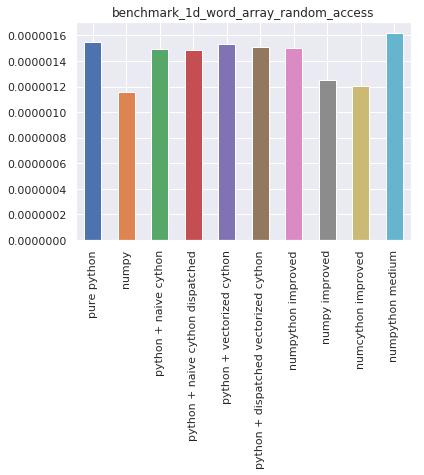

In [96]:
plot("benchmark_1d_word_array_random_access")

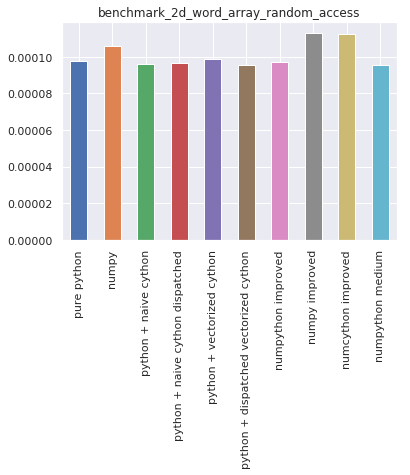

In [98]:
plot("benchmark_2d_word_array_random_access")

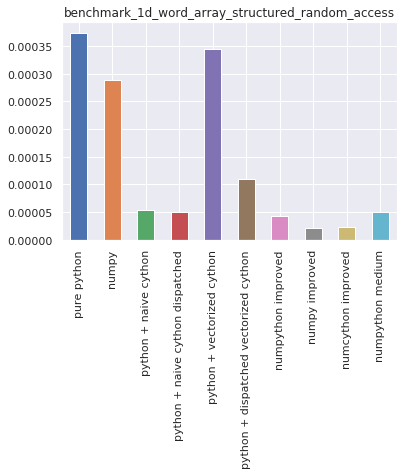

In [99]:
plot("benchmark_1d_word_array_structured_random_access")

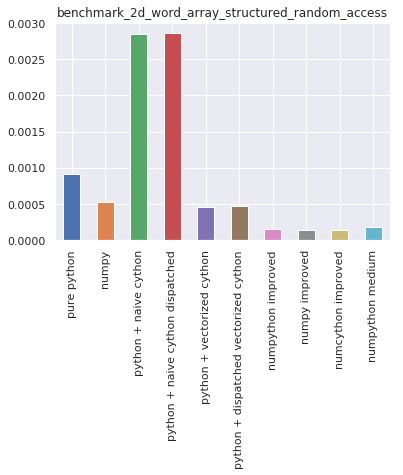

In [100]:
plot("benchmark_2d_word_array_structured_random_access")

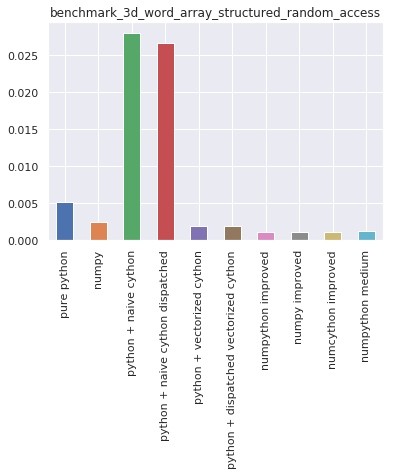

In [101]:
plot("benchmark_3d_word_array_structured_random_access")

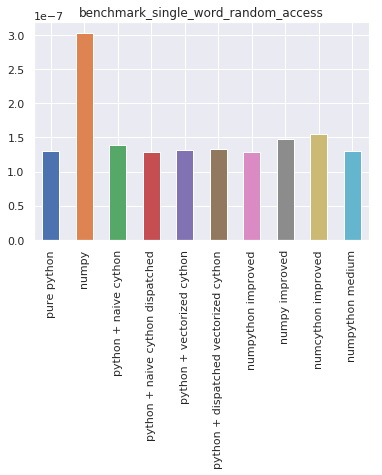

In [102]:
plot("benchmark_single_word_random_access")